## **Store Item Demand Forecasting**

Note: This uses Kaggle dataset known as "Store Item Demand Forecasting Challenge". It provides 5 years of store-item sales data, that consist of 50 different items at 10 different stores. More details at: <br> 
www.kaggle.com/competitions/demand-forecasting-kernels-only/data.

In [1]:
# Set up path for data files
from google.colab import drive
drive.mount("/content/drive" )

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Forecasting/'

In [3]:
!jupyter nbconvert --to html /content/drive/MyDrive/Forecasting/xgboos.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Forecasting/xgboos.ipynb to html
[NbConvertApp] Writing 527935 bytes to /content/drive/MyDrive/Forecasting/xgboos.html


In [ ]:
# Libraries are imported
import pandas as pd
import numpy as np
import math
from datetime import date
from datetime import datetime as dt
import calendar, holidays

import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
from scipy import signal

## 1) Reading Data and Evaluating

In [ ]:
df = pd.read_csv(path+'train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
# Checking for null values
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [ ]:
# Looking for number of unique values
df.nunique()

date     1826
store      10
item       50
sales     213
dtype: int64

In [ ]:
# convert the Purchase Date to datetime object
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [ ]:
min(df.date.dt.year)

2013

In [ ]:
# Determing the range of date
print(max(df.date).strftime('%Y-%m-%d')) # oldest
print(min(df.date).strftime('%Y-%m-%d')) # earliest

2017-12-31
2013-01-01


In [ ]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


## 2) Feature Engineering

In [ ]:
# Creating additional features
df["year"] = df['date'].dt.year
df["month"] = df['date'].dt.month
df["day"] = df['date'].dt.day
df["week_of_year"] = df['date'].dt.weekofyear
# df["day_of_year"] = df['date'].dt.day_of_year

<ipython-input-14-aec51f542f2f>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["week_of_year"] = df['date'].dt.weekofyear


In [ ]:
df.head()

,date,store,item,sales,year,month,day,week_of_year
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,1
2,2013-01-03,1,1,14,2013,1,3,1
3,2013-01-04,1,1,13,2013,1,4,1
4,2013-01-05,1,1,10,2013,1,5,1


In [ ]:
df.date[10].weekday()

4

In [ ]:
# Function to identify sales during weekends
def weekend(d):
  if d.weekday()>4:
      return 1
  else:
      return 0

In [ ]:
# Creating additional feature
df['weekend'] = df.date.apply(weekend)

In [ ]:
df.head(3)

,date,store,item,sales,year,month,day,week_of_year,weekend
0,2013-01-01,1,1,13,2013,1,1,1,0
1,2013-01-02,1,1,11,2013,1,2,1,0
2,2013-01-03,1,1,14,2013,1,3,1,0


In [ ]:
df.weekend.unique()

array([0, 1])

In [ ]:
# Function identifies holidays in the USA
def is_holiday(x):
  us_holidays = holidays.country_holidays('USA')
  if us_holidays.get(x):
    return 1
  else:
    return 0

In [ ]:
#holidays.USA(years = 2000)
a = holidays.country_holidays('USA')
print(a.get(df.date.loc[0]))

New Year's Day


In [ ]:
a.get('2013-01-01')

"New Year's Day"

In [ ]:
# Creating additional feature
df['holidays'] = df['date'].apply(is_holiday)


In [ ]:
df.head(3)

,date,store,item,sales,year,month,day,week_of_year,weekend,holidays
0,2013-01-01,1,1,13,2013,1,1,1,0,1
1,2013-01-02,1,1,11,2013,1,2,1,0,0
2,2013-01-03,1,1,14,2013,1,3,1,0,0


In [ ]:
# Saving intermediate data to a file
df.to_csv(path +'tsifile.csv')

In [ ]:
# Function identifies day of the week (week starts on Monday)
def which_wday(d):
  return d.weekday()

In [ ]:
# Creating additional feature
df['weekday'] = df['date'].apply(which_wday)

In [ ]:
df.head(3)

,date,store,item,sales,year,month,day,week_of_year,weekend,holidays,weekday
0,2013-01-01,1,1,13,2013,1,1,1,0,1,1
1,2013-01-02,1,1,11,2013,1,2,1,0,0,2
2,2013-01-03,1,1,14,2013,1,3,1,0,0,3


## 3) Exploratory Visualization

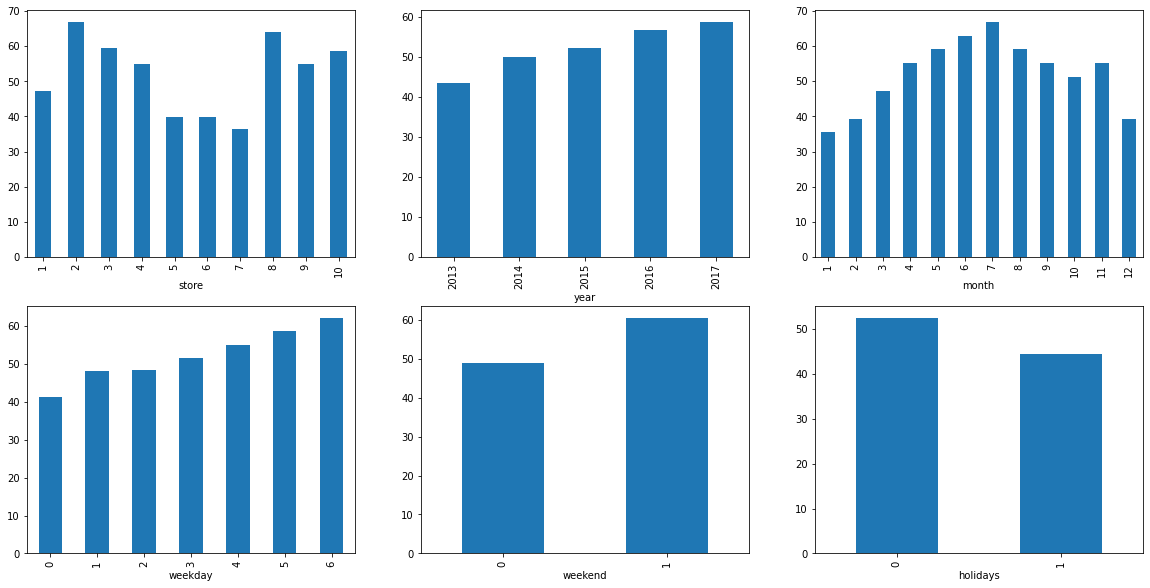

In [ ]:
features = ['store', 'year', 'month','weekday', 'weekend', 'holidays']

plt.subplots(figsize=(20, 10))
for i, col in enumerate(features):
  plt.subplot(2, 3, i + 1)
  df.groupby(col).mean()['sales'].plot.bar()
plt.show()

### 3.1) Observation on seasonality

- Weekends have more sales than weekdays
- Sales are steadily increasing during the week starting from Monday
- Sakes peaked during Summer and then in November
- Sales are loweer during holidays
- Sales steadily increasing from 2013 to 2017

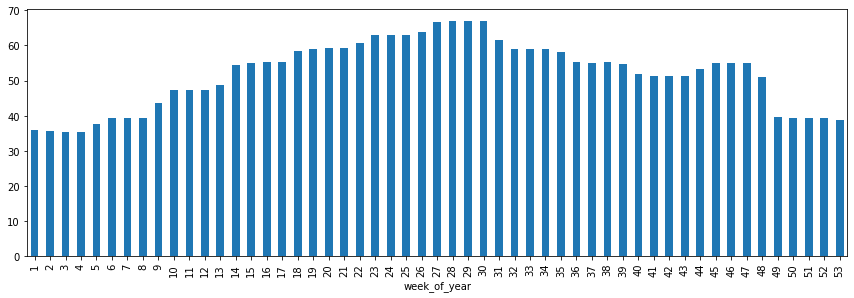

In [ ]:
features = ['week_of_year']

plt.subplots(figsize=(50, 10))
for i, col in enumerate(features):
  plt.subplot(2, 3, i + 1)
  df.groupby(col).mean()['sales'].plot.bar()
plt.show()

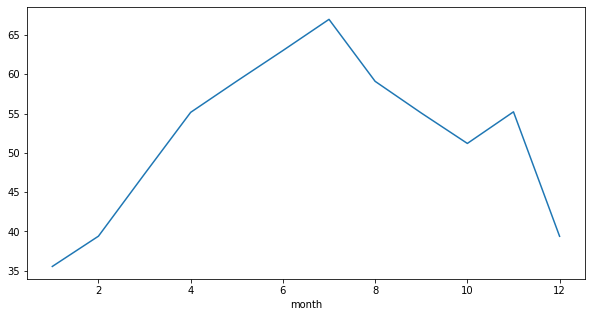

In [ ]:
# Monthly trend
plt.figure(figsize=(10,5))
df.groupby('month').mean()['sales'].plot()
plt.show()

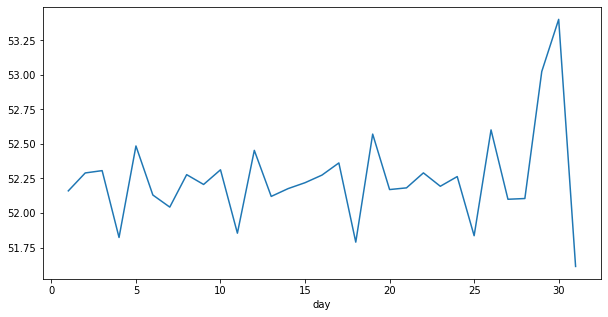

In [ ]:
plt.figure(figsize=(10,5))
df.groupby('day').mean()['sales'].plot()
plt.show()

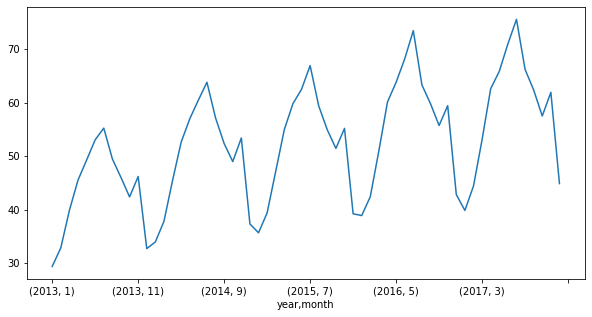

In [ ]:
plt.figure(figsize=(10,5))
df.groupby(['year', 'month']).mean()['sales'].plot()

### 3.2) Observation on seasonality, trend and cyclic nature

- Seasonality, cyclic nature and trends are present <br>
Note: Based on these observations, additinal features are derived to model seasonality, cyclic nature and thre trend

## 4) Additional Feature Engineering

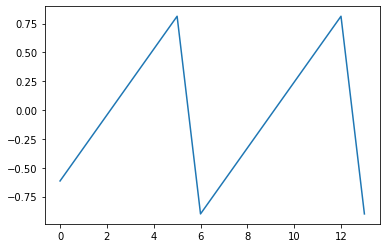

In [ ]:
# Plot the sawtooth wave
b = (signal.sawtooth(df['weekday']*2 * np.pi /7) + 0.1)

n = np.linspace(0, 1, 100, endpoint=True)
plt.plot(b[:14])

In [ ]:
# Deriving cyclical features from weekday
df['w_stooth'] = (signal.sawtooth(df['weekday']*2 * np.pi /7) + 0.1)
# Deriving cyclical features from month
df['m_stooth'] = (signal.sawtooth(df['month']*2 * np.pi /12) + 0.1)

# Deriving trend feature from week_of_year
df['wno_stooth'] = (signal.sawtooth(df['week_of_year']*2 * np.pi /52) + 0.1)

In [ ]:
df.head(3)

,date,store,item,sales,year,month,day,week_of_year,weekend,holidays,weekday,w_stooth,m_stooth,wno_stooth
0,2013-01-01,1,1,13,2013,1,1,1,0,1,1,-0.614286,-0.733333,-0.861538
1,2013-01-02,1,1,11,2013,1,2,1,0,0,2,-0.328571,-0.733333,-0.861538
2,2013-01-03,1,1,14,2013,1,3,1,0,0,3,-0.042857,-0.733333,-0.861538


In [ ]:
# Getting the number of days
from calendar import monthrange
df['c_days'] = df[['year', 'month']].apply(lambda x: monthrange(*x)[1], axis=1)

In [ ]:
df.head(3)

,date,store,item,sales,year,month,day,week_of_year,weekend,holidays,weekday,w_stooth,m_stooth,wno_stooth,c_days
0,2013-01-01,1,1,13,2013,1,1,1,0,1,1,-0.614286,-0.733333,-0.861538,31
1,2013-01-02,1,1,11,2013,1,2,1,0,0,2,-0.328571,-0.733333,-0.861538,31
2,2013-01-03,1,1,14,2013,1,3,1,0,0,3,-0.042857,-0.733333,-0.861538,31


In [ ]:
# Deriving cyclical features for the days
df['d_stooth'] = (signal.sawtooth(df['day']*2 * np.pi /df['c_days']) + 0.1)

In [ ]:
df.head(3)

,date,store,item,sales,year,month,day,week_of_year,weekend,holidays,weekday,w_stooth,m_stooth,wno_stooth,c_days,d_stooth
0,2013-01-01,1,1,13,2013,1,1,1,0,1,1,-0.614286,-0.733333,-0.861538,31,-0.835484
1,2013-01-02,1,1,11,2013,1,2,1,0,0,2,-0.328571,-0.733333,-0.861538,31,-0.770968
2,2013-01-03,1,1,14,2013,1,3,1,0,0,3,-0.042857,-0.733333,-0.861538,31,-0.706452


In [ ]:
# Deriving trend feature from year 
df['fyear'] = 1 + pd.factorize(df['year'])[0]

In [ ]:
df.fyear.values

array([1, 1, 1, ..., 5, 5, 5])

In [ ]:
df.head(3)

,date,store,item,sales,year,month,day,week_of_year,weekend,holidays,weekday,w_stooth,m_stooth,wno_stooth,c_days,d_stooth,fyear
0,2013-01-01,1,1,13,2013,1,1,1,0,1,1,-0.614286,-0.733333,-0.861538,31,-0.835484,1
1,2013-01-02,1,1,11,2013,1,2,1,0,0,2,-0.328571,-0.733333,-0.861538,31,-0.770968,1
2,2013-01-03,1,1,14,2013,1,3,1,0,0,3,-0.042857,-0.733333,-0.861538,31,-0.706452,1


In [ ]:
# Saving intermediate data
df.to_csv(path + 'tsi2file.csv')

In [ ]:
# Dropping columns that are not needed
df.drop( ['year', 'c_days', 'date', 'month', 'day', 'week_of_year'], axis = 1, inplace = True)
#df.drop( ['c_days'], axis = 1, inplace = True)

In [ ]:
df.head(3)

,store,item,sales,weekend,holidays,weekday,w_stooth,m_stooth,wno_stooth,d_stooth,fyear
0,1,1,13,0,1,1,-0.614286,-0.733333,-0.861538,-0.835484,1
1,1,1,11,0,0,2,-0.328571,-0.733333,-0.861538,-0.770968,1
2,1,1,14,0,0,3,-0.042857,-0.733333,-0.861538,-0.706452,1


In [ ]:
# Normalizing selected columns
cols = ['fyear', 'sales', 'store', 'item']
features = df[cols]

sc = StandardScaler()
features = sc.fit(features.values).transform(features.values)

In [ ]:
# Reassigning normalized features to dataframe
df[cols] = features
# df[cols] = pd.DataFrame(features, columns=cols)
df.head()

,store,item,sales,weekend,holidays,weekday,w_stooth,m_stooth,wno_stooth,d_stooth,fyear
0,-1.566699,-1.697749,-1.362804,0,1,1,-0.614286,-0.733333,-0.861538,-0.835484,-1.414795
1,-1.566699,-1.697749,-1.432246,0,0,2,-0.328571,-0.733333,-0.861538,-0.770968,-1.414795
2,-1.566699,-1.697749,-1.328083,0,0,3,-0.042857,-0.733333,-0.861538,-0.706452,-1.414795
3,-1.566699,-1.697749,-1.362804,0,0,4,0.242857,-0.733333,-0.861538,-0.641935,-1.414795
4,-1.566699,-1.697749,-1.466966,1,0,5,0.528571,-0.733333,-0.861538,-0.577419,-1.414795


## 5) Model fitting and Validating

In [ ]:
# Extracting independent and dependent values from dataframe
x = df.drop(['sales'], axis=1)
y = df['sales']

In [ ]:
# Separating validation set
X_train, X_val, Y_train, Y_val = train_test_split(x , y, test_size = 0.05, random_state=22)
X_train.shape, X_val.shape

((867350, 10), (45650, 10))

In [ ]:
# Fitting a XFBoost regressor
model = XGBRegressor(objective="reg:squarederror", random_state=415)
model.fit(X_train, Y_train)

XGBRegressor(objective='reg:squarederror', random_state=415)

In [ ]:
# Evaluating error on validation set
train_preds = model.predict(X_train)
print('Training Error : ', mae(Y_train, train_preds))

val_preds = model.predict(X_val)
print('Validation Error : ', mae(Y_val, val_preds))
print()

Training Error :  0.41427402940742014
Validation Error :  0.4152412039857782



## 6) Takeaway

- The model fit was validated as it gave similar error on training and validation
- On this common data, most MAE's that I seen are just under 12. Therefore, this is about 96.6% (11.5/11.9*100) reduction in error.